In [1]:
import os
import numpy as np
# from PIL import Image
import torch
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter

import copy

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 12

In [4]:
torch.cuda.is_available()

True

In [5]:
def concatenate_tr_by_column(p_all_list):
    # First, concatenate the arrays within each tr by column
    combined_tr_list = [np.concatenate(tr, axis=1) for tr in p_all_list]

    # Now, concatenate all combined tr arrays by column as well
    p_all = np.concatenate(combined_tr_list, axis=1)
    
    return p_all

In [6]:
cutoff = 0

In [12]:
p_all_list_mix_weighted = torch.load('./result_pred_p_mix_weighted/pred_p_list_all_epoch200.pth')
p_all_list_mix_weighted_Mul = torch.load('./result_pred_p_mix_weighted_Mul/pred_p_list_all_epoch200.pth')

In [13]:
p_all_list_mix_weighted = p_all_list_mix_weighted[cutoff:]
p_all_list_mix_weighted_Mul = p_all_list_mix_weighted_Mul[cutoff:]

In [14]:
print(len(p_all_list_mix_weighted))
print(len(p_all_list_mix_weighted[0]))
print(p_all_list_mix_weighted[0][0].shape)

80
6
(1000, 10)


In [15]:
p_all_mix_weighted = concatenate_tr_by_column(p_all_list_mix_weighted)
p_all_mix_weighted_Mul = concatenate_tr_by_column(p_all_list_mix_weighted_Mul)
print(p_all_mix_weighted.shape)
print(p_all_mix_weighted_Mul.shape)

(1000, 4800)
(2000, 4800)


In [16]:
equal_weight = np.ones(p_all_mix_weighted.shape[1]//10)
equal_weight_Mul = np.ones(p_all_mix_weighted_Mul.shape[1]//10)

In [9]:
# Define the dataset
class ProteinDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.sequences = dataframe['Sequence'].values
        self.labels = dataframe['Label'].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            sequence,
            return_tensors="pt",
            padding="max_length",  
            truncation=True,       
            max_length=1000        
        )
        return inputs, torch.tensor(label, dtype=torch.long)


In [10]:
df_test = pd.read_csv("./Datasets/deeploc/data_our/data_our_test.csv")
df_test_Mul = pd.read_csv("./Datasets/deeploc/data_Mul/data_MuLabel_sub.csv")

In [11]:
print("df_test.shape: ", df_test.shape)
print("df_test_Mul.shape: ", df_test_Mul.shape)

df_test.shape:  (1000, 16)
df_test_Mul.shape:  (2000, 18)


In [12]:
# get true labels
test_labels = df_test['Label']
labels = test_labels.tolist()

## get MLE acc

In [24]:
from scipy.stats import gaussian_kde
from functools import partial

In [25]:
def weighted_MLE(data, weights):
    if len(np.unique(data))==1:
        mle = np.unique(data)[0]
    else: 
        # Generate the KDE
        kde = gaussian_kde(data, weights=weights)
        # Evaluate the KDE on a grid
        grid = np.linspace(max(0,min(data)-0.05), min(1,max(data)+0.05), 600)
        density = kde(grid)
        # MLE:
        mle = grid[np.argmax(density)]
    
    return mle

In [26]:
def get_p_MLE(data, weights=equal_weight):
    mle_p = []
    for i in range(10):
        data_p = data[i::10]
        mle_p.append(weighted_MLE(data_p, weights))
    mle_p = np.array(mle_p)
    mle_p = mle_p/mle_p.sum()
    return mle_p

In [27]:
MLE_mix_weighted = np.apply_along_axis(get_p_MLE, 1, p_all_mix_weighted, equal_weight)
pred_mix_weighted = np.argmax(MLE_mix_weighted, axis=1)
np.mean(pred_mix_weighted==labels)

0.622

In [28]:
os.makedirs("./result_pred_deviance_infer", exist_ok=True)

In [29]:
np.save("./result_pred_deviance_infer/MLE_mix_weighted.npy", MLE_mix_weighted)

In [25]:
MLE_mix_weighted = np.load("./result_pred_deviance_infer/MLE_mix_weighted.npy")

In [30]:
MLE_mix_weighted_Mul = np.apply_along_axis(get_p_MLE, 1, p_all_mix_weighted_Mul, equal_weight_Mul)
pred_mix_weighted_Mul = np.argmax(MLE_mix_weighted_Mul, axis=1)

In [31]:
np.save("./result_pred_deviance_infer/MLE_mix_weighted_Mul.npy", MLE_mix_weighted_Mul)

## bayesian deviance CI

In [32]:
def get_rate_each_image(pi, up, weight, dim=10):
    arr_reshaped = pi.reshape(-1, 10)
    normalized_arr_reshaped = arr_reshaped / arr_reshaped.sum(axis=1, keepdims=True)
    pi = normalized_arr_reshaped.flatten()
    
    r = 0
    for k in range(dim):
        p_tmp = pi[k::dim]
        r_tmp = p_tmp*np.where( (p_tmp>=up), 1, 0 )
        r += r_tmp
    rate = np.average(r, weights=weight)
    return rate


def dichotomy_optimal_up(pi, weight, dim=10, target_rate=0.95, tol=1e-12):
    low, high = 0.0, 1.0
    
    rate_old = 0; mid_old = 0
    while high - low > tol:
        mid = (low + high) / 2
        rate = get_rate_each_image(pi, mid, weight, dim=dim)
        
        if np.abs(rate-target_rate)>(0.5+np.abs(rate_old-target_rate)):
            return mid_old
        mid_old = copy.deepcopy(mid)
        rate_old = copy.deepcopy(rate)
        
        if rate > target_rate:
            low = mid
        else:
            high = mid
            
    return (low + high) / 2


def get_CI_rate(predicted_probabilities, weight, dim=10, rate=0.95):
    optimal_up_dichotomy = dichotomy_optimal_up(predicted_probabilities, weight=weight, dim=dim, target_rate=rate)
    optimal_rate = get_rate_each_image(predicted_probabilities, optimal_up_dichotomy, weight, dim=dim)
    
    CI_up = -2*np.log(optimal_up_dichotomy)

    return CI_up, optimal_rate

### mean of deviance:
Do not use the built condidence band to measure the uncertainty of the predions (as this will lead to problems). We calculate the deviance of each image, and use the mean of the deviance as the measure of prediction uncertainty.

In [3]:
def weighted_quantile(values, quantiles, weight=None):
    """
    Calculate the weighted quantile
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if weight is None:
        weight = np.ones(len(values))
    weight = np.array(weight)
    sorter = np.argsort(values)
    values = values[sorter]
    weight = weight[sorter]
    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)
    return np.interp(quantiles, weighted_quantiles, values)


In [4]:
def get_mean_dev_each_image(pi, weight, dim=10):
    dev = 0
    for k in range(dim):
        p_tmp = pi[k::dim]
        dev_tmp = -2*np.log(p_tmp)*p_tmp
        dev_tmp[p_tmp==0] =0
        dev += dev_tmp
    # print("dev shape:", dev.shape)
    mm = np.average(dev, weights=weight)
    return mm

def get_quantile_dev_each_image(pi, y, weight, quant=0.85, dim=10):
    dev = 0
    for k in range(dim):
        p_tmp = pi[k::dim]
        dev_tmp = -2*np.log(p_tmp)*p_tmp
        dev += dev_tmp
    # print("dev shape:", dev.shape)
    mm = weighted_quantile(dev, quant, weight=equal_weight)
    return mm

In [48]:
# BKD, mix weighted
Y_pred = np.argmax(MLE_mix_weighted, axis=1)

In [49]:
mean_dev_each = []
for i in range(p_all_mix_weighted.shape[0]):
    rr = get_mean_dev_each_image(p_all_mix_weighted[i,:], weight=equal_weight)
    mean_dev_each.append(rr)

In [50]:
mean_dev_each = np.array(mean_dev_each)
np.save("./result_pred_deviance_infer/mean_dev_each_mix_weighted.npy", mean_dev_each)

In [5]:
mean_dev_each = np.load("./result_pred_deviance_infer/mean_dev_each_mix_weighted.npy")

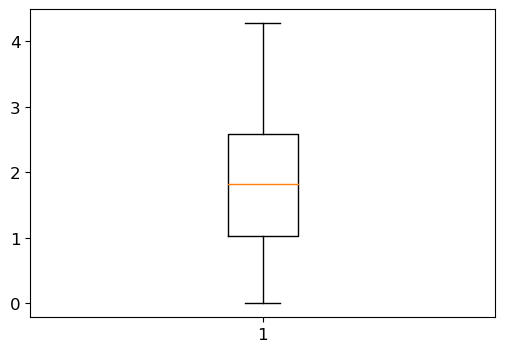

In [51]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
plt.boxplot(mean_dev_each)
plt.show()

In [60]:
mean_dev_each_Mul = []
for i in range(p_all_mix_weighted_Mul.shape[0]):
    rr = get_mean_dev_each_image(p_all_mix_weighted_Mul[i,:], weight=equal_weight_Mul)
    mean_dev_each_Mul.append(rr)
    
mean_dev_each_Mul = np.array(mean_dev_each_Mul)
np.save("./result_pred_deviance_infer/mean_dev_each_mix_weighted_Mul.npy", mean_dev_each_Mul)

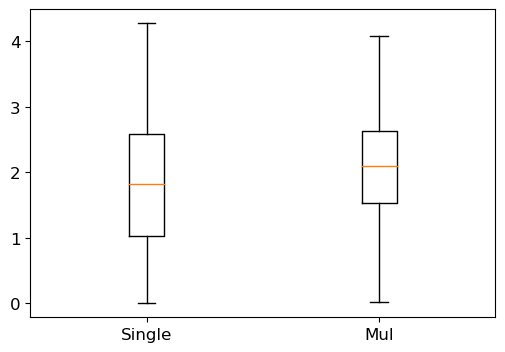

In [62]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
plt.boxplot([mean_dev_each,mean_dev_each_Mul], labels=['Single', 'Mul'])
plt.show()

In [6]:
mean_dev_each_Mul = np.load("./result_pred_deviance_infer/mean_dev_each_mix_weighted_Mul.npy")

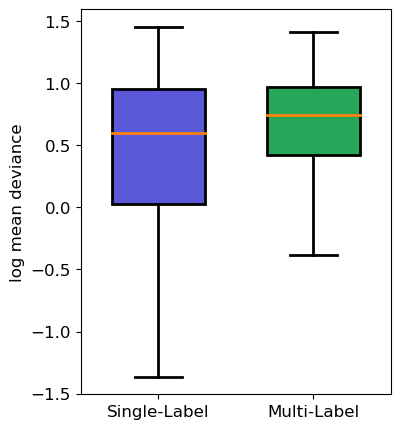

In [45]:
dat_bxplot = [np.log(mean_dev_each), np.log(mean_dev_each_Mul)]
dat_bxplot_filtered = [np.array([v for v in group if v >= -10]) for group in dat_bxplot]

# Define properties for boxplot components with wider lines
boxprops = dict(linestyle='-', linewidth=2)
whiskerprops = dict(linestyle='-', linewidth=2)
capprops = dict(linewidth=2)
medianprops = dict(linestyle='-', linewidth=2)

fig = plt.figure(figsize=(4, 5), facecolor='white')
bp = plt.boxplot(dat_bxplot_filtered, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            patch_artist=True,
            showfliers=False,
            widths=0.6,
            labels=['Single-Label', 'Multi-Label'])
bp['boxes'][0].set_facecolor((0.35, 0.35, 0.85))
bp['boxes'][1].set_facecolor((0.15, 0.65, 0.35))

plt.ylabel('log mean deviance')
plt.show()

##### each class

In [47]:
dat_bxplot = [np.log(mean_dev_each)]
for i in range(10):
    label_to_find = i
    indices_with_label = [index for index, label in enumerate(labels) if label == label_to_find]
    mean_dev_label = np.log(np.array(mean_dev_each))[indices_with_label]
    dat_bxplot.append(mean_dev_label)

In [49]:
x_labels = ['all'] + df_test.columns[4:14].values.tolist()

In [33]:
x_labels

['all',
 'Cytoplasm',
 'Nucleus',
 'Extracellular',
 'Cell membrane',
 'Mitochondrion',
 'Plastid',
 'Endoplasmic reticulum',
 'Lysosome/Vacuole',
 'Golgi apparatus',
 'Peroxisome']

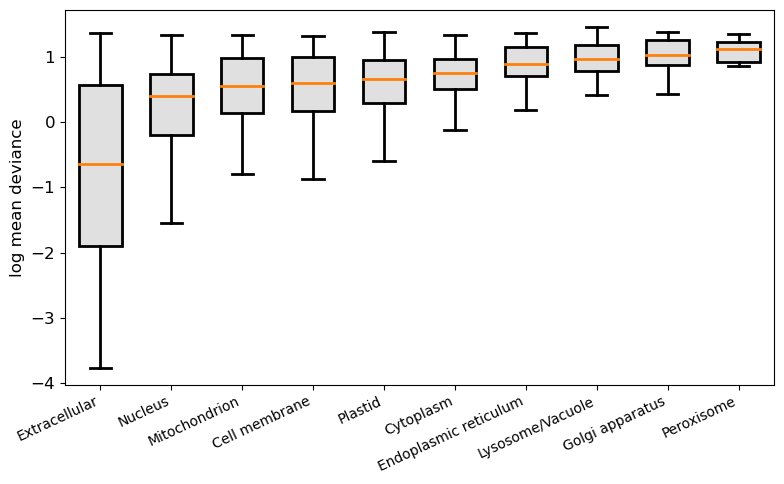

In [55]:
dat_bxplot_filtered = [np.array([v for v in group if v >= -10]) for group in dat_bxplot[1:]]

other_groups = dat_bxplot_filtered[0:]

medians = [np.median(group) for group in other_groups]

sorted_indices = np.argsort(medians)
sorted_groups = [other_groups[i] for i in sorted_indices]
sorted_labels = [x_labels[i + 1] for i in sorted_indices]  # Offset by 1 to skip "all"

dat_bxplot_ordered = sorted_groups
x_labels_ordered = sorted_labels

#
boxprops = dict(linestyle='-', linewidth=2)
whiskerprops = dict(linestyle='-', linewidth=2)
capprops = dict(linewidth=2)
medianprops = dict(linestyle='-', linewidth=2)

# Create the plot
fig = plt.figure(figsize=(8, 5), facecolor='white')
bp = plt.boxplot(
    dat_bxplot_ordered, 
    boxprops=boxprops, 
    whiskerprops=whiskerprops, 
    capprops=capprops, 
    medianprops=medianprops,
    patch_artist=True,
    showfliers=False,
    widths=0.6
)


light_color = '#e0e0e0'
for box in bp['boxes'][0:]:
    box.set_facecolor(light_color)  

plt.ylabel('log mean deviance')
plt.xticks(np.arange(1, len(x_labels_ordered)+1 ), x_labels_ordered, rotation=25, ha='right', fontsize=10)

plt.tight_layout()
plt.show()
